# TESTS

In [ ]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
from workflow import *
from datetime import datetime

DT_FMT = "%Y-%m-%d %H:%M:%S"


# COMPARE TRANSPORT BETWEEN SOLVERS

In [ ]:
sim_names = ['mt3dms', 'mf6gwt', 'mf6gwtapi']
ws = os.path.join('benchmark')

fig, axs = plt.subplots(3, 1, figsize=(6.3,10.2))

for sim_name, ax in zip(sim_names, axs.flatten()):
    if sim_name == 'mt3dms':
        ucname = 'MT3D001'
    else:
        ucname = 'tracer'
    ucn = flopy.utils.HeadFile(os.path.join(ws, sim_name, f"{ucname}.UCN"),text=f"concentration")
    results = ucn.get_alldata()
    times = ucn.get_times()
    r_tf = results[-1, 0, 0,:]
    ax.plot(r_tf)

In [ ]:
sim_names = ['mt3dms', 'mf6gwt', 'mf6gwtapi']
ws = os.path.join('benchmark')

x = np.arange(0.005,0.505,0.01)

fig, axs = plt.subplots(1, 1, figsize=(6.3,3.3))
ax = axs
for e, sim_name in enumerate(sim_names):
    if sim_name == 'mt3dms':
        ucname = 'MT3D001'
    else:
        ucname = 'tracer'
    ucn = flopy.utils.HeadFile(os.path.join(ws, sim_name, f"{ucname}.UCN"),text=f"concentration")
    results = ucn.get_alldata()
    times = ucn.get_times()
    r_tf = results[-1, 0, 0,:]
    ax.plot(x, r_tf, label = sim_name, linewidth= 5-e*1.5, alpha = 0.6+e/5)
    ax.legend()
    ax.set_ylabel('Conc mol (m$^{-3}$)')
    ax.set_xlabel('Distance (m)')
fig.tight_layout()

In [ ]:
sim_name = 'mf6gwtapi'
ws = os.path.join('benchmark')
ucn = flopy.utils.HeadFile(os.path.join(ws,sim_name, f"tracer.UCN"),text=f"concentration")
# ucn = flopy.utils.UcnFile(os.path.join(ws,sim_name, f"MT3D001.UCN"))
results = ucn.get_alldata()
results
times = ucn.get_times()

fig, axs = plt.subplots(1, 1, figsize=(6.3,3.2))
ax = axs
r_tf = results[-1, 0, 0,:]
ax.plot(r_tf)

# MF6 API TEST

In [ ]:
sim_ws = Path("model/engesgaard1992/")
dll = Path("bin/win/libmf6")

In [ ]:
def try_get_value(address, mf6):
    try:
        res = mf6.get_value(address)
        return res
    except:
        res = 'failed'
        return res

In [ ]:
mf6 = modflowapi.ModflowApi(dll, working_directory = sim_ws)
mf6.initialize()
# current_time = mf6.get_current_time()
# end_time = mf6.get_end_time()
all_vars = mf6.get_input_var_names() 
mf6.get_subcomponent_count()

# try:
#     mf6.finalize()
#     success=True
# except:
#     raise RuntimeError

In [ ]:
sim = ApiSimulation.load(mf6)
len(ApiSimulation.load(mf6).solutions)

In [ ]:
model = sim.get_model(sim.models[1].name)
model.solution_id


In [ ]:
# current_time, end_time

# all_vars
df_vars = pd.DataFrame(all_vars)[0].str.split('/', expand=True)
df_vars['addr'] = all_vars
# df_vars.to_csv('vars.csv')

In [ ]:
welaux = mf6.get_value(mf6.get_var_address("AUXVAR", 'GWF/WEL'))
welaux[0][-1] = 0
mf6.set_value('GWF/WEL/AUXVAR', welaux)
# mf6.get_value(mf6.get_var_address("x", 'SODIUM')) = val

In [ ]:
mf6.get_value(mf6.get_var_address("AUXVAR", 'GWF/WEL'))
# mf6.finalize()

In [ ]:
welaux = mf6.get_value(mf6.get_var_address("AUXVAR", 'GWF/WEL'))
welaux[0][-1] = 100
# mf6.set_value("AUXVAR", 'GWF/WEL')
mf6.set_value('GWF/WEL/AUXVAR', welaux)

In [ ]:

mf6 = modflowapi.ModflowApi(dll, working_directory = sim_ws)
mf6.initialize()

sim_start = datetime.now()
print("...starting transport solution at {0}".format(sim_start.strftime(DT_FMT)))
# reset the node tracking containers

# get the current sim time
ctime = mf6.get_current_time()
ctimes = [0.0]
# get the ending sim time
etime = mf6.get_end_time()
# max number of solution iterations
max_iter = mf6.get_value(mf6.get_var_address("MXITER", "SLN_1"))
num_fails = 0
# let's do it!
while ctime < etime:
    sol_start = datetime.now()
    # length of the current solve time
    dt = mf6.get_time_step()
    # prep the current time step
    mf6.prepare_time_step(dt)
    kiter = 0
    # prep to solve
    mf6.prepare_solve(1)
    # the one-based stress period number
    stress_period = mf6.get_value(mf6.get_var_address("KPER", "TDIS"))[0]
    time_step = mf6.get_value(mf6.get_var_address("KSTP", "TDIS"))[0]

    # solve until converged
    while kiter < max_iter:
        # apply whatever change we want here
        # val = mf6.get_value(mf6.get_var_address("x", 'SODIUM'))
        # val += 1
        convg = mf6.solve(1)
        if convg:
            td = (datetime.now() - sol_start).total_seconds() / 60.0
            print("transport stress period,time step {0},{1} converged with {2} iters, took {3:10.5G} mins".format(stress_period, time_step, kiter,td))
            break
        kiter += 1

    if not convg:
        td = (datetime.now() - sol_start).total_seconds() / 60.0
        print("transport stress period,time step {0},{1} did not converged, {2} iters, took {3:10.5G} mins".format(
            stress_period, time_step, kiter, td))
        num_fails += 1
mf6.finalize()


# PHREEQCRM TESTS

In [ ]:
import phreeqcrm
import numpy as np
import sys
import pandas as pd
from pathlib import Path
import os
import modflowapi
from modflowapi import Callbacks
from workflow import *
from datetime import datetime


In [ ]:
print_selected_output_on = True
print_selected_output_on

In [ ]:
nxyz = 50
nthreads = 1
phreeqc_rm = phreeqcrm.PhreeqcRM(nxyz, nthreads)

status = phreeqc_rm.SetComponentH2O(False)
phreeqc_rm.UseSolutionDensityVolume(False)
status = phreeqc_rm.SetFilePrefix("engesgaard1992")
phreeqc_rm.OpenFiles()
poro = np.full((nxyz), .1)
status = phreeqc_rm.SetPorosity(poro)

print_chemistry_mask = np.full((nxyz), 1)
status = phreeqc_rm.SetPrintChemistryMask(print_chemistry_mask)
nchem = phreeqc_rm.GetChemistryCellCount()
nchem

# init_file = 'phinp.dat'
init_file = 'advect.pqi'

# Load database
databasews = os.path.join("database", "pht3d_datab.dat")
status = phreeqc_rm.LoadDatabase(databasews)
status = phreeqc_rm.RunFile(True, True, True, init_file)# Clear contents of workers and utility
input = "DELETE; -all"
status = phreeqc_rm.RunString(True, False, True, input)

ncomps = phreeqc_rm.FindComponents()
ncomps

components = phreeqc_rm.GetComponents()
components

for comp in components:
    phreeqc_rm.OutputMessage(comp)
phreeqc_rm.OutputMessage("\n")

In [ ]:


for comp in components:
    phreeqc_rm.OutputMessage(comp)
phreeqc_rm.OutputMessage("\n")

ic1 = [-1] * nxyz * 7 
ic1
for i in range(nxyz):
    ic1[i]            =  1  # Solution 1
    ic1[nxyz + i]     = 1  # Equilibrium phases none
    ic1[2 * nxyz + i] =  -1  # Exchange 1
    ic1[3 * nxyz + i] = -1  # Surface none
    ic1[4 * nxyz + i] = -1  # Gas phase none
    ic1[5 * nxyz + i] = -1  # Solid solutions none
    ic1[6 * nxyz + i] = -1  # Kinetics none

status = phreeqc_rm.InitialPhreeqc2Module(ic1)

# Initial equilibration of cells
time = 0.0
time_step = 0.0
status = phreeqc_rm.SetTime(time)
status = phreeqc_rm.SetTimeStep(time_step)
status = phreeqc_rm.RunCells()


In [ ]:
status

c_dbl_vect = phreeqc_rm.GetConcentrations()


In [ ]:
#ncomp * ncell

ncomps*nxyz, components


In [ ]:
phreeqc_rm.GetSpeciesNames()
phreeqc_rm.GetSpeciesConcentrations()

In [ ]:
phreeqc_rm.GetSpeciesNames()


In [ ]:
phreeqc_rm.GetDatabaseFileName()
components
phreeqc_rm.GetEquilibriumPhases()
# phreeqc_rm.SetConcentrations()

In [ ]:
components

In [ ]:
# status
c_dbl_vect = phreeqc_rm.GetConcentrations()

In [ ]:
nlay = 1  # Number of layers
Lx = 0.5 #m
ncol = 50  # Number of columns
nrow = 1  

n=nxyz

conc = [c_dbl_vect[i:i + n] for i in range(0, len(c_dbl_vect), n)]

sconc = {}
for e, c in enumerate(components):
    sconc[c] = np.reshape(conc[e], (nlay, nrow, ncol))
sconc

for c in components:
    print(sconc[c].dtype)
# sconc


In [ ]:
ic1 = [-1] * 50 * 7 
len(ic1)

In [ ]:
# sim = build_model(ws = 'model', sim_name = 'engesgaard1992', spls = components, sconc=sconc)

# strt

In [ ]:
components

In [ ]:
def flatten_list(xss):
    return [x for xs in xss for x in xs]


In [ ]:
# sim_ws = os.path.join('model', '1dtest', 'chloride')
sim_ws = Path("model/engesgaard1992/")
dll = Path("bin/win/libmf6")

mf6 = modflowapi.ModflowApi(dll, working_directory = sim_ws)
mf6.initialize()


sim_start = datetime.now()
print("...starting transport solution at {0}".format(sim_start.strftime(DT_FMT)))
# reset the node tracking containers

# get the current sim time
ctime = mf6.get_current_time()
ctimes = [0.0]
# get the ending sim time
etime = mf6.get_end_time()
# max number of solution iterations
max_iter = mf6.get_value(mf6.get_var_address("MXITER", "SLN_2"))
num_fails = 0
# let's do it!
while ctime < etime:
    sol_start = datetime.now()
    # length of the current solve time
    dt = mf6.get_time_step()
    # prep the current time step
    mf6.prepare_time_step(dt)
    kiter = 0
    # prep to solve
    mf6.prepare_solve(1)
    # the one-based stress period number
    stress_period = mf6.get_value(mf6.get_var_address("KPER", "TDIS"))[0]
    time_step = mf6.get_value(mf6.get_var_address("KSTP", "TDIS"))[0]

    # array to store transported components
    print(f'\nGetting concentration arrays --- time step: {time_step} --- elapsed time: {ctime}')
    mf6_conc_array = [mf6.get_value(mf6.get_var_address("X", f'{c.upper()}')) for c in components]
    c_dbl_vect = flatten_list(mf6_conc_array)

    phreeqc_rm.SetScreenOn(True)
    print_selected_output_on = (ctime == etime)
    print_chemistry_on = (ctime == etime)
    status = phreeqc_rm.SetSelectedOutputOn(True)
    status = phreeqc_rm.SetPrintChemistryOn(print_chemistry_on, False, False) 

    status = phreeqc_rm.SetConcentrations(c_dbl_vect)  
    message = 'Beginning reaction calculation               {} days\n'.format(ctime)
    phreeqc_rm.LogMessage(message)
    phreeqc_rm.ScreenMessage(message)
    status = phreeqc_rm.RunCells()

    # Transfer data from PhreeqcRM for transport
    #status = phreeqc_rm.GetConcentrations(c_dbl_vect)
    c_dbl_vect = phreeqc_rm.GetConcentrations()

    conc = [c_dbl_vect[i:i + n] for i in range(0, len(c_dbl_vect), n)]
    sconc = {}
    for e, c in enumerate(components):
        sconc[c] = np.reshape(conc[e], (nlay, nrow, ncol))

    # solve transport until converged
    for c in components:
        print(f'\nSolving for component: {c}')
        while kiter < max_iter:
            # print(list(mf6_conc_array))
            if c == 'mg':
                mf6.set_value(f'{c.upper()}/X', sconc[c]+100)
            else:
                mf6.set_value(f'{c.upper()}/X', sconc[c])
            convg = mf6.solve(1)
            if convg:
                td = (datetime.now() - sol_start).total_seconds() / 60.0
                print("Transport stress period: {0} --- time step: {1} --- converged with {2} iters --- took {3:10.5G} mins".format(stress_period, time_step, kiter,td))
                break
            kiter += 1

    if not convg:
        td = (datetime.now() - sol_start).total_seconds() / 60.0
        print("transport stress period {0}, time step {1}, did not converged, {2} iters, took {3:10.5G} mins".format(
            stress_period, time_step, kiter, td))
        num_fails += 1
    try:
        mf6.finalize_solve(1)
    except:
        pass
    mf6.finalize_time_step()
    # update the current time tracking
    ctime = mf6.get_current_time()
# sim = flopy.mf6.MFSimulation.load('engesgaard1992', 'mf6', 'mf6' , os.path.join('model', 'engesgaard1992'))
# plot_concentrations(sim)
sim_end = datetime.now()
td = (sim_end - sim_start).total_seconds() / 60.0
print("\n...transport solution finished at {0}, took: {1:10.5G} mins".format(sim_end.strftime(DT_FMT),td))
if num_fails > 0:
    print("...failed to converge {0} times".format(num_fails))
print("\n")
status = phreeqc_rm.CloseFiles()
status = phreeqc_rm.MpiWorkerBreak()
mf6.finalize()

In [ ]:
[c_dbl_vect[i:i + n] for i in range(0, len(c_dbl_vect), n)]
sconc

# Engesgaard 1992 - PHT3D vs MF6

In [1]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
from workflow import *
from datetime import datetime

DT_FMT = "%Y-%m-%d %H:%M:%S"


In [3]:
wd = os.path.join('benchmark', 'pht3d')
dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)
# simdf.columns = [col.lower() for col in simdf.columns]
simdf.loc[:, 'x'] = simdf['cell'] * dx 
simdf.drop(columns = 'H', inplace = True)
display(simdf)

Lx = 0.5 #m
ncol = 50  # Number of columns
delr = Lx/ncol

simapi = pd.read_csv(os.path.join( 'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr

# simapi['time_d'] = list(simdf.index)*1
# simapi.index = simapi['time_d'] 
simapi = simapi[simdf.columns]
simapi

,cell,pH,pe,Ca,Cl,C4,Mg,Calcite,Dolomite,x
time_d,,,,,,,,,,
0.01,1.0,9.7017,-6.5533,0.000131,1.120800e-03,0.000085,5.149000e-04,0.000000,0.000045,0.01
0.01,2.0,9.8379,-6.7482,0.000165,3.727800e-04,0.000108,1.295300e-04,0.000000,0.000057,0.02
0.01,3.0,9.9058,-6.8288,0.000125,9.186700e-05,0.000125,4.593300e-05,0.000115,0.000000,0.03
0.01,4.0,9.9087,-6.8347,0.000123,2.438000e-05,0.000123,1.219000e-05,0.000120,0.000000,0.04
0.01,5.0,9.9095,-6.8362,0.000123,6.540100e-06,0.000123,3.270100e-06,0.000122,0.000000,0.05
...,...,...,...,...,...,...,...,...,...,...
0.24,46.0,9.9098,9.2597,0.000123,2.570300e-09,0.000123,1.016700e-09,0.000122,0.000000,0.46
0.24,47.0,9.9098,9.2388,0.000123,1.203100e-09,0.000123,4.788200e-10,0.000122,0.000000,0.47
0.24,48.0,9.9098,9.2703,0.000123,5.550500e-10,0.000123,2.222000e-10,0.000122,0.000000,0.48


,cell,pH,pe,Ca,Cl,C4,Mg,Calcite,Dolomite,x
time_d,,,,,,,,,,
0.00,0.0,9.909348,9.811934,0.000123,1.000000e-18,0.000123,9.997978e-19,0.000122,0.0,0.01
0.00,1.0,9.909348,9.811934,0.000123,1.000000e-18,0.000123,9.997978e-19,0.000122,0.0,0.02
0.00,2.0,9.909348,9.811934,0.000123,1.000000e-18,0.000123,9.997978e-19,0.000122,0.0,0.03
0.00,3.0,9.909348,9.811934,0.000123,1.000000e-18,0.000123,9.997978e-19,0.000122,0.0,0.04
0.00,4.0,9.909348,9.811934,0.000123,1.000000e-18,0.000123,9.997978e-19,0.000122,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...
0.24,45.0,9.909296,9.812029,0.000123,3.575399e-07,0.000123,1.417241e-07,0.000122,0.0,0.46
0.24,46.0,9.909314,9.811999,0.000123,2.346336e-07,0.000123,9.352241e-08,0.000122,0.0,0.47
0.24,47.0,9.909326,9.811978,0.000123,1.529875e-07,0.000123,6.130273e-08,0.000122,0.0,0.48


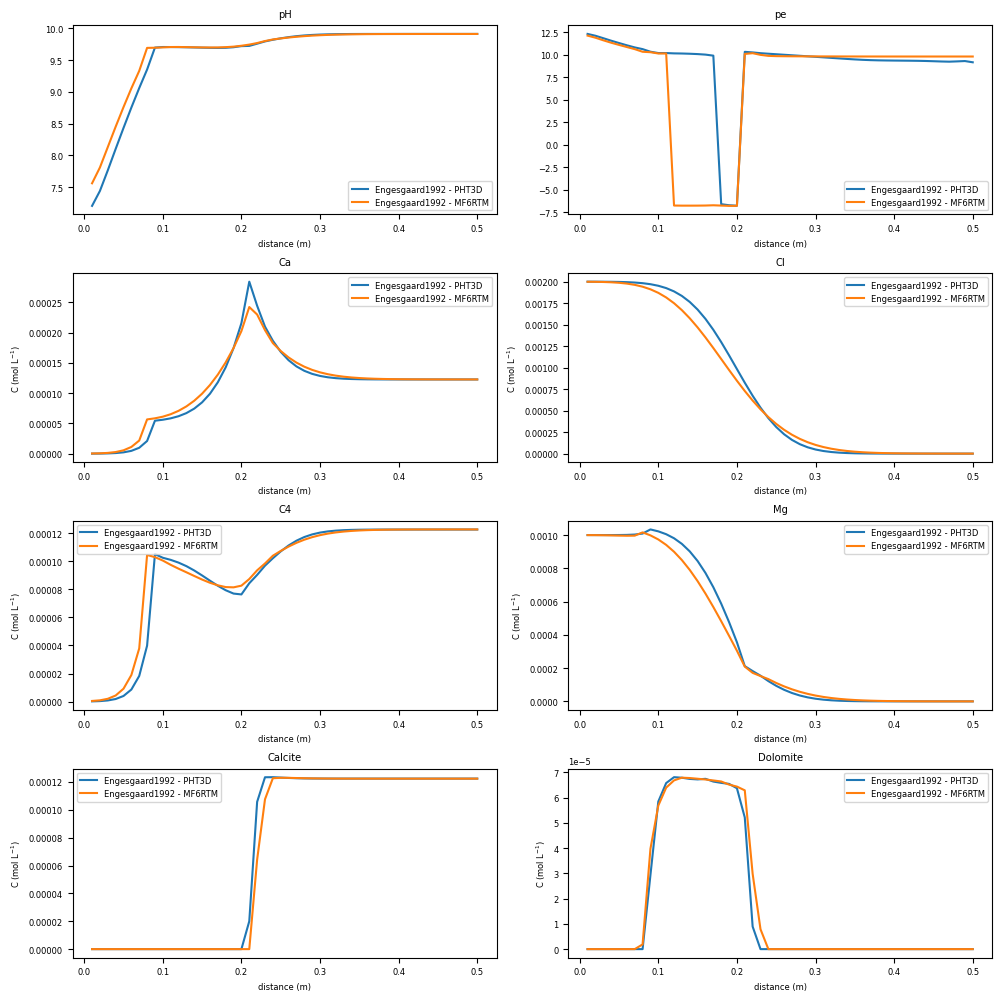

In [5]:
fig, axs = plt.subplots(4,2, figsize = (10, 10))
t = 0.24
for var, ax in zip(simdf.iloc[:,1:-1 ].columns, axs.flatten()):
    ax.plot(simdf.x.unique(), simdf.loc[t, var], label = 'Engesgaard1992 - PHT3D')
    ax.plot(simapi.x.unique(), simapi.loc[t, var], label = 'Engesgaard1992 - MF6RTM')
    ax.set_xlabel('distance (m)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L$^{-1}$)')
    ax.set_title(f'{var}')
    ax.legend()
fig.tight_layout()

In [ ]:
simdf.loc[0.24, ['x','Calcite']].pivot_table(index='x', columns = 'time_d').plot();
simdf.loc[0.24, ['x','Mg']].pivot_table(index='x', columns = 'time_d').plot() 

In [ ]:
# C_4 = loadtxt('PHT3D001.ACN')
# Ca = loadtxt('PHT3D002.ACN')
# Cl = loadtxt('PHT3D003.ACN')
# Mg = loadtxt('PHT3D004.ACN')
# pH = loadtxt('PHT3D005.ACN')
# pe = loadtxt('PHT3D006.ACN')



In [ ]:
ucn_dic = {'c':1,'ca':2, 'cl':3, 'mg':4, 'h':5, 'charge':6}

comps = list(ucn_dic.keys())[:]
# comps.extend(['h2o'])

# comps = [ 'h', 'c']

for i in [0, 10, 15, 23]:
    sim_ws = os.path.join('model', 'engesgaard1992api')
    wd = os.path.join('benchmark', 'pht3d')

    sim = flopy.mf6.MFSimulation.load('engesgaard1992api', 'mf6', 'mf6', sim_ws, verbosity_level=0)
    nrow = len(comps)
    fig, axs = plt.subplots(nrow, 1, figsize=(3.3,8.2))

    for c, ax in zip(comps, axs.flatten()):
        gwf = sim.get_model(c)

        ucn = flopy.utils.HeadFile(os.path.join("model",sim.name,f"{c}.ucn"),text="concentration")
        results = ucn.get_alldata()
        times = gwf.output.concentration().get_times()

        ucn_pht = flopy.utils.HeadFile(os.path.join(wd,f"PHT3D00{ucn_dic[c]}.ucn"),text="concentration")
        results_pht = ucn_pht.get_alldata()
        times_pht = ucn_pht.get_times()
        
        # ax.plot(np.log(concentration_m3_to_l(results[i, 0, 0,:])), label = 'mf6api')
        ax.set_title(f"{c}")
        # ax.plot(times, concentration_m3_to_l(results[:, 0, 0,-1]), label = 'mf6api')
        # ax.plot(times_pht, results_pht[:, 0, 0,25], label = 'pht3d')
        ax.plot(results_pht[i, 0, 0,:], label = 'pht3d')
        if c in ['h3', 'charges']:
            # ax.plot(np.log(results_pht[i, 0, 0,:]), label = 'pht3d')
            ax.plot(np.log(concentration_m3_to_l(results[i, 0, 0,:])), label = 'mf6api')
            # print(np.log(results_pht[i, 0, 0,:]))
        else:
            ax.plot(concentration_m3_to_l(results[i, 0, 0,:]), label = 'mf6api')
        ax.set_ylabel('Conc (mol/L)')
        ax.set_xlabel('Time')
        ax.legend()
    fig.tight_layout()
    plt.show()

In [ ]:
comps

In [30]:
from PIL import Image

def mrbeaker():
    # Load the image of Mr. Beaker
    mr_beaker_image = Image.open("mrbeaker.png")

    # Resize the image to fit the terminal width
    terminal_width = 80  # Adjust this based on your terminal width
    aspect_ratio = mr_beaker_image.width / mr_beaker_image.height
    terminal_height = int(terminal_width / aspect_ratio)
    mr_beaker_image = mr_beaker_image.resize((terminal_width, terminal_height))

    # Convert the image to grayscale
    mr_beaker_image = mr_beaker_image.convert("L")

    # Convert the grayscale image to ASCII art
    ascii_chars = "%,.?>#*+=-:."

    mrbeaker = ""
    for y in range(mr_beaker_image.height):
        for x in range(mr_beaker_image.width):
            pixel_value = mr_beaker_image.getpixel((x, y))
            mrbeaker += ascii_chars[pixel_value // 32]
        mrbeaker += "\n"
    return mrbeaker

print(ascii_art)

IndexError: string index out of range